# Project : Telco Customer Churn

Telco Customer Churn Dataset contains information about customers of a telecommunications company and whether they have left the service (churn) or not. In this project, we will identify retain customer behavior using EDA and then apply predictive analytics methods to forecast which customers are most likely to churn.

Source : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

About the data:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import joblib

### Data Preprocessing

In [ ]:
data=pd.read_csv("D:/DS/telco_customer_churn.csv", na_values=' ')
data.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Check duplication
data.duplicated().any()

False

In [ ]:
# Check null
data.isnull().sum()

CustomerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
# Replace missing data by mean
mean = round(float(data['TotalCharges'].mean(skipna=True)),2)
data['TotalCharges'].fillna(mean, inplace=True)

In [115]:
data.nunique()

CustomerID          7043
Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
Tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

In [116]:
data['SeniorCitizen']=data['SeniorCitizen'].astype('object')

In [ ]:
# Identify quantitative and qualitative variables
num_cols=data.select_dtypes('number').columns
print('Biến định lượng: ', num_cols)
cat_cols=data.select_dtypes('object').columns.drop('CustomerID')
print('Biến định tính: ', cat_cols)

Biến định lượng:  Index(['Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
Biến định tính:  Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [118]:
for col in cat_cols:
    print(col, ': ', data[col].unique())

Gender :  ['Female' 'Male']
SeniorCitizen :  [0 1]
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn :  ['No' 'Yes']


In [ ]:
data.replace('No phone service','No', inplace=True)
data.replace('No internet service','No', inplace=True)

In [120]:
for col in cat_cols:
    print(col, ': ', data[col].unique())

Gender :  ['Female' 'Male']
SeniorCitizen :  [0 1]
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes']
OnlineBackup :  ['Yes' 'No']
DeviceProtection :  ['No' 'Yes']
TechSupport :  ['No' 'Yes']
StreamingTV :  ['No' 'Yes']
StreamingMovies :  ['No' 'Yes']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn :  ['No' 'Yes']


In [ ]:
le=LabelEncoder()
for col in cat_cols.drop('SeniorCitizen'):
    data[col]=le.fit_transform(data[col])

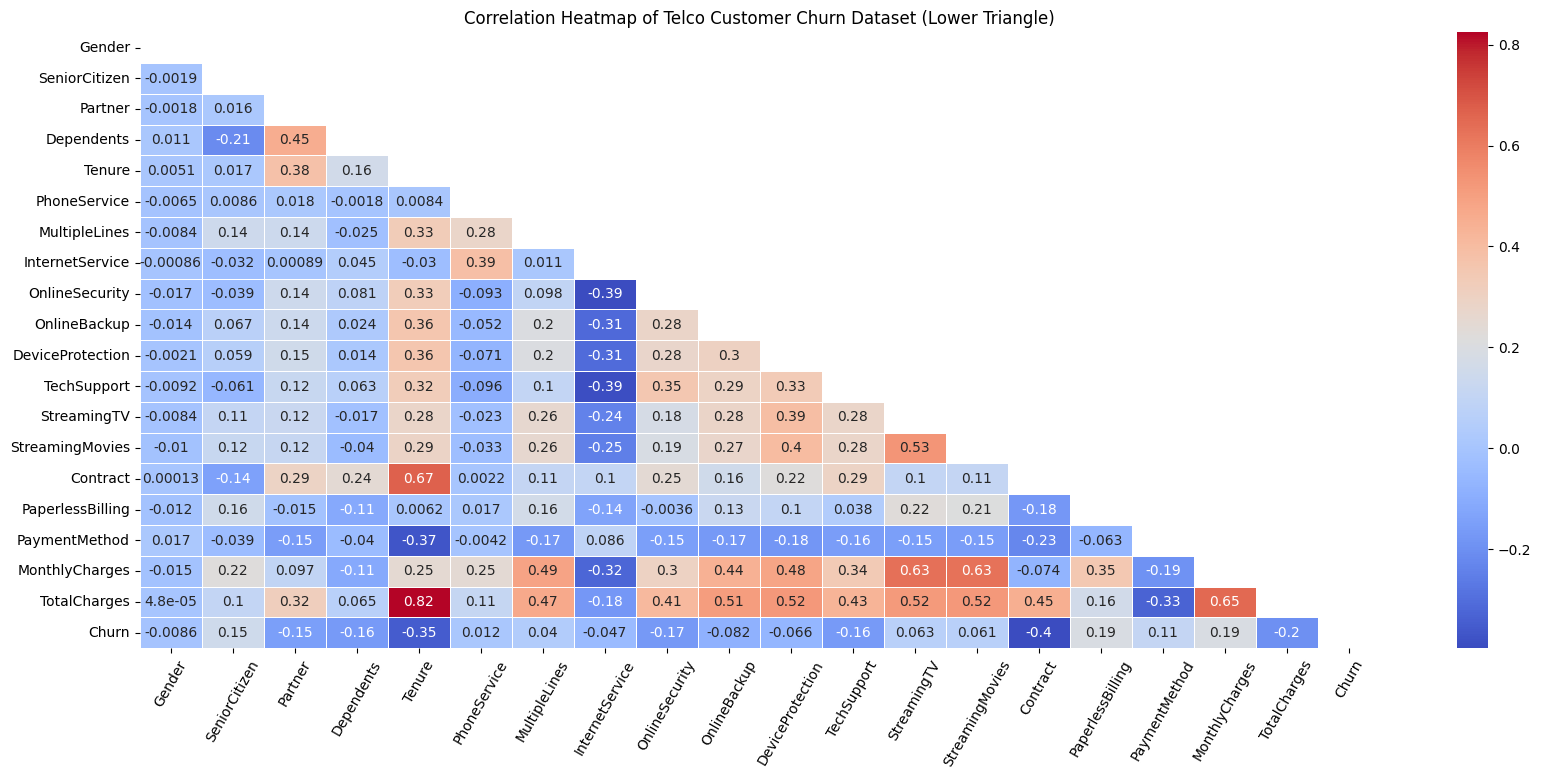

In [ ]:
corr_matrix=data.drop(columns='CustomerID').corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2g')
plt.title('Correlation Heatmap of Telco Customer Churn Dataset (Lower Triangle)')
plt.xticks(rotation=60)
plt.show()

In [123]:
data.corr()['Churn'].sort_values(ascending=False)

Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
StreamingTV         0.063228
StreamingMovies     0.061382
MultipleLines       0.040102
PhoneService        0.011942
Gender             -0.008612
InternetService    -0.047291
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Partner            -0.150448
Dependents         -0.164221
TechSupport        -0.164674
OnlineSecurity     -0.171226
TotalCharges       -0.199428
Tenure             -0.352229
Contract           -0.396713
Name: Churn, dtype: float64

Overall, the variables do not show a strong correlation with Churn, with the correlation levels being relatively low. Among all the variables, *Tenure* and *Contract* have the strongest negative correlation, while the *Gender* variable has the lowest correlation.

In [ ]:
data[num_cols].describe()

,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2283.300440
std,24.559481,30.090047,2265.000258
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1400.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


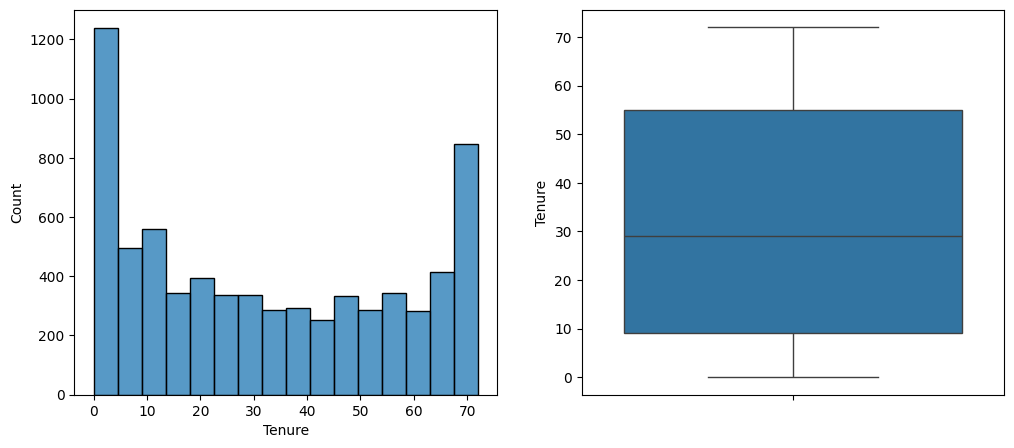

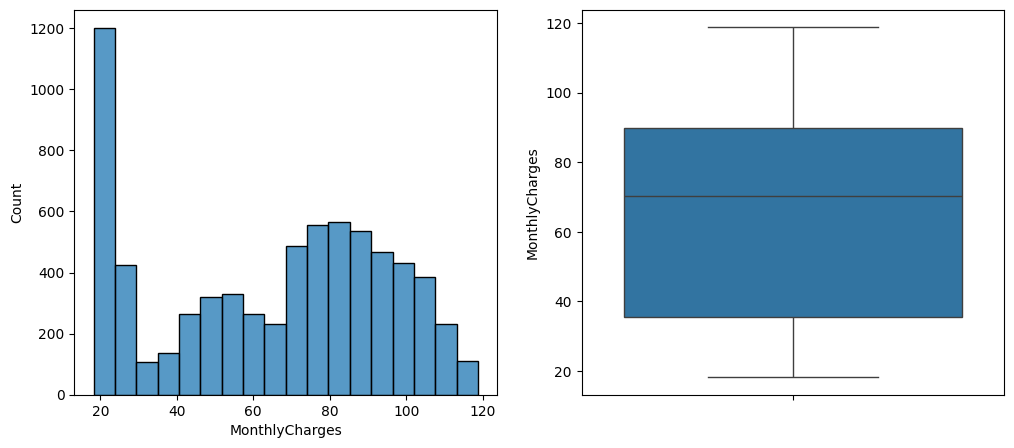

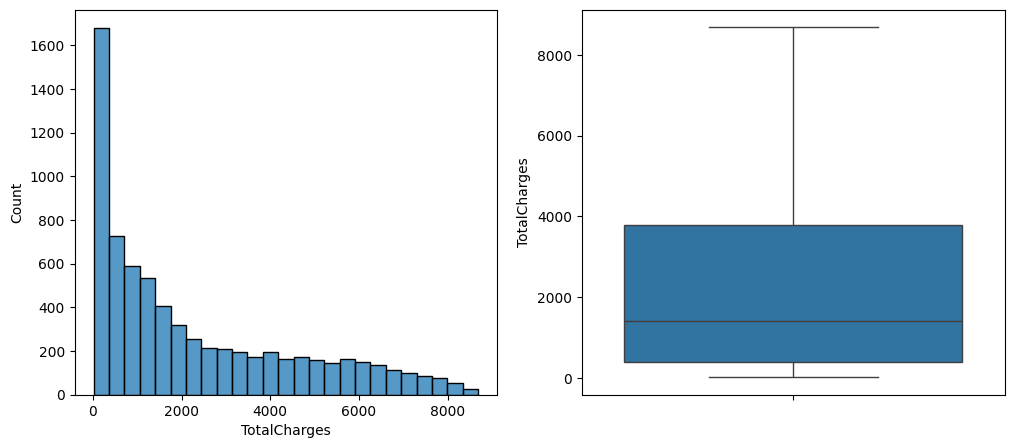

In [ ]:
for col in num_cols:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    ax1=sns.histplot(data=data, x=col)
    plt.subplot(1,2,2)
    ax2=sns.boxplot(data=data, y=col)
    plt.show()    

The three quantitative variables do not have any outliers. However, they are on different and fairly large scales, so data scaling is necessary when building the model.

### Build a Logistic Regression model to predict the likelihood of customers churning

In [124]:
X=data.drop(columns=['CustomerID','Churn'])
y=data['Churn']

In [125]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

The sample size between the two classes is imbalanced.

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [127]:
ros=RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

In [128]:
scaler=StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])

In [24]:
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}

model_grid = GridSearchCV(LogisticRegression(), grid_params, cv=5)
model_grid.fit(X_train,y_train)
print('Logistic Regression')
print('Accuracy score:', model_grid.best_score_)
print('Parameters:',model_grid.best_params_)

Logistic Regression
Accuracy score: 0.759697386519945
Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [129]:
model=LogisticRegression(C=1, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [130]:
y_pred=model.predict(X_test)
print('Accuracy of Train: ',model.score(X_train, y_train))
print('Accuracy of Test: ',model.score(X_test, y_test))
score = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(score, recall, prec, f1)

Accuracy of Train:  0.758321870701513
Accuracy of Test:  0.7520113582584004
0.7520113582584004 0.837979094076655 0.5274122807017544 0.6473755047106325


In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1539
           1       0.53      0.84      0.65       574

    accuracy                           0.76      2113
   macro avg       0.73      0.78      0.73      2113
weighted avg       0.82      0.76      0.77      2113



The model predicts correctly about 76% of the time, with class 0 being predicted more accurately than class 1.

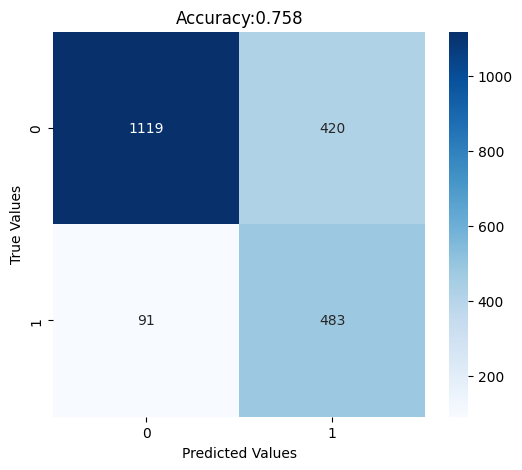

In [28]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

The model correctly predicts a significant number of customers who actually churn, but it also incorrectly predicts many non-churning customers as churners. Therefore, the model needs improvement.

## Evaluate the stability of the model using k-fold Cross Validation

In [29]:
score=cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
print(score)
print(score.mean(), score.std())

[0.75034388 0.75171939 0.77028886 0.75309491 0.7696011 ]
0.7590096286107291 0.008973593634277896


After 5 iterations, the Accuracy Score ranged from 0.74 to 0.77, with a low standard deviation of 0.007, indicating that the model is quite stable.

## Pipeline
We can build a pipeline to streamline the steps. This pipeline will help automate the process of data preprocessing, feature scaling, model training, and evaluation, making it more efficient and reproducible

In [ ]:
cat_cols=['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
num_cols=['Tenure', 'MonthlyCharges', 'TotalCharges']

def preprocessing(X):
    X_new = X.copy()

    X_new.replace('No phone service','No', inplace=True)
    X_new.replace('No internet service','No', inplace=True)

    for col in cat_cols:
        X_new[col].fillna(X_new[col].mode(dropna=True)[0], inplace=True)

    for col in num_cols:
        mean = round(float(X_new[col].mean(skipna=True)), 2)
        X_new[col].fillna(mean, inplace=True)

    return X_new

preprocessing_transform = FunctionTransformer(preprocessing, validate=False)

column_transform=ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_cols), 
                                                 ('num', StandardScaler(), num_cols)])

model_pipeline=Pipeline(steps=[('preprocessing', preprocessing_transform),
                               ('column_transform', column_transform),
                               ('Logistic_Regression_Model', LogisticRegression())])

In [31]:
# Train model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocessing at 0x000001E15FA77E20>)),
                ('column_transform',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['Tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('Logistic_Regression_Model', LogisticRegression())])

In [ ]:
# Save model
joblib.dump(model_pipeline, 'Telco_Customer_Churn_Pipeline.pkl')
print('Mô hình đã được lưu!')

Mô hình đã được lưu!


In [ ]:
# Load model
loaded_model=joblib.load('Telco_Customer_Churn.pkl')
loaded_model

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocessing at 0x000001AC71C065F0>)),
                ('column_transform',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['Tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('Logistic_Regression_Model', LogisticRegression())])

In [ ]:
y_pred=loaded_model.predict(X_test)

print('Accuracy of Train: ',loaded_model.score(X_train, y_train))
print('Accuracy of Test: ',loaded_model.score(X_test, y_test))
score = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(score, recall, prec, f1)

Accuracy of Train:  0.7616231086657497
Accuracy of Test:  0.7586370089919545
0.7586370089919545 0.8432055749128919 0.5353982300884956 0.6549391069012178


## Determine the algorithm with the optimal parameters

In [253]:
# SVC
grid_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

model_grid_svc = GridSearchCV(SVC(), grid_params, cv=5)
model_grid_svc.fit(X_train,y_train)
print('SVC')
print('Accuracy score:', model_grid_svc.best_score_)
print('Parameters:', model_grid_svc.best_params_)

SVC
Accuracy score: 0.8522696011004125
Parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}


In [37]:
# Decision Tree
grid_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
}
model_grid_dt = GridSearchCV(DecisionTreeClassifier(), grid_params, cv=5)
model_grid_dt.fit(X_train,y_train)
print('Decision Tree')
print('Accuracy score:', model_grid_dt.best_score_)
print('Parameters:', model_grid_dt.best_params_)

Decision Tree
Accuracy score: 0.8790921595598349
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [255]:
# Random Forest
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
model_rf = RandomForestClassifier(n_jobs=-1) 
model_grid_rf = GridSearchCV(model_rf, grid_params, cv=5)
model_grid_rf.fit(X_train,y_train)
print('Random Forest')
print('Accuracy score:', model_grid_rf.best_score_)
print('Parameters:', model_grid_rf.best_params_)

Random Forest
Accuracy score: 0.9070151306740029
Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [256]:
# KNN
grid_params = {'n_neighbors' : [3,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

model_grid_knn = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5)
model_grid_knn.fit(X_train,y_train)
print('KNN')
print('Accuracy score:', model_grid_knn.best_score_)
print('Parameters:', model_grid_knn.best_params_)

KNN
Accuracy score: 0.8393397524071528
Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [257]:
# AdaBoost
grid_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

model_ada = AdaBoostClassifier() 
grid_search_ada = GridSearchCV(estimator=model_ada, param_grid=grid_params, scoring='accuracy', cv=5)
grid_search_ada.fit(X_train, y_train)
print('AdaBoost')
print('Accuracy score:', grid_search_ada.best_score_)
print('Parameters:', grid_search_ada.best_params_)

AdaBoost
Accuracy score: 0.7751031636863823
Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100}


In [258]:
# XGBoost
grid_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3,5,7],
    'subsample': [0.8, 1.0],
    'colsample_bytree' : [0.8, 1.0]
}

model_xg = xgb.XGBClassifier() 
grid_search_xg = GridSearchCV(estimator=model_xg, param_grid=grid_params, scoring='accuracy', cv=5)
grid_search_xg.fit(X_train, y_train)
print('XGBoost')
print('Accuracy score:', grid_search_xg.best_score_)
print('Parameters:', grid_search_xg.best_params_)

XGBoost
Accuracy score: 0.8962861072902338
Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


Random Forest has the best accuracy score on the training dataset among all the algorithms. However, further analysis of the prediction results for each class is needed to draw a final conclusion.

In [ ]:
# Evaluate XGBoost model
best_xg = grid_search_xg.best_estimator_

y_pred = best_xg.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7709417889256981 0.7089375425918001 0.7103246501663704 0.5761821366024519


In [278]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1539
           1       0.58      0.57      0.58       574

    accuracy                           0.77      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.77      0.77      0.77      2113



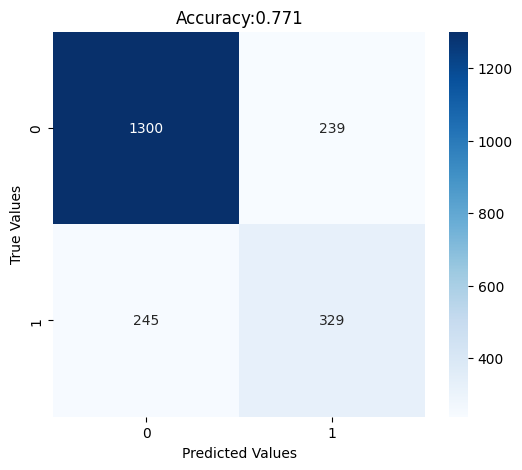

In [279]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

Although XGBoost model has a high accuracy score on the training set, its performance on the test set is lower, with a significant gap between the two. The model also struggles to predict class 1 (churn) effectively.

In [ ]:
# Evaluate Decision Tree model 
best_dt = model_grid_dt.best_estimator_

y_pred = best_dt.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7292948414576431 0.6503068873629422 0.6551914369400011 0.48928571428571427


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1539
           1       0.50      0.48      0.49       574

    accuracy                           0.73      2113
   macro avg       0.66      0.65      0.65      2113
weighted avg       0.73      0.73      0.73      2113



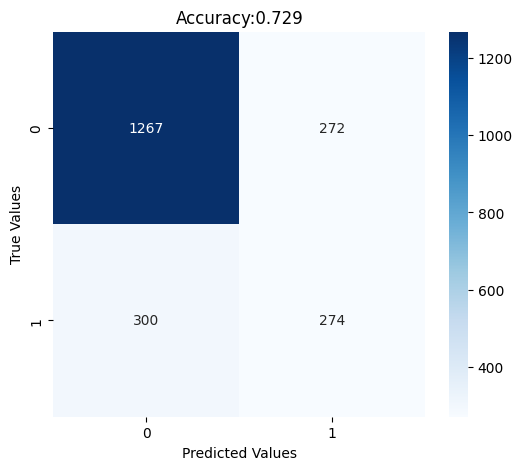

In [42]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

Although the Decision Tree model has a high accuracy score on the training set, its performance on the test set is lower, with a significant gap between the two. The model also performs poorly in predicting class 1 (churn).

In [ ]:
# Evaluate KNN model 
best_knn = model_grid_knn.best_estimator_

y_pred = best_knn.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7108376715570279 0.6955328701156686 0.6646857707283773 0.5543398978847557


In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1539
           1       0.48      0.66      0.55       574

    accuracy                           0.71      2113
   macro avg       0.66      0.70      0.67      2113
weighted avg       0.75      0.71      0.72      2113



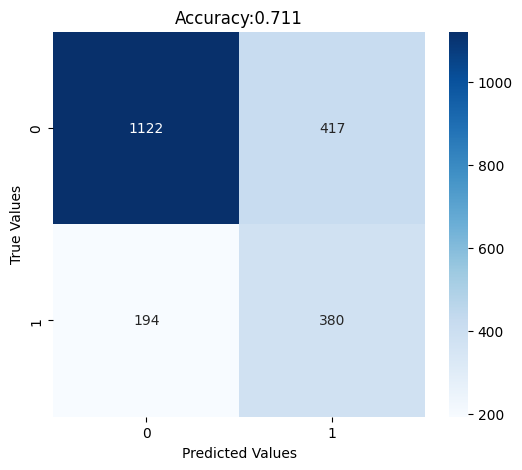

In [285]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

Although KNN model has a high accuracy score on the training set, its performance on the test set is lower, with a significant gap between the two. However, it performs better than the other algorithms in predicting class 1 (churn).

In [ ]:
# Evaluate Random Forest model
best_rf = model_grid_rf.best_estimator_

y_pred = best_rf.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7870326549929011 0.7259918087902684 0.730610887012933 0.6017699115044248


In [287]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1539
           1       0.61      0.59      0.60       574

    accuracy                           0.79      2113
   macro avg       0.73      0.73      0.73      2113
weighted avg       0.79      0.79      0.79      2113



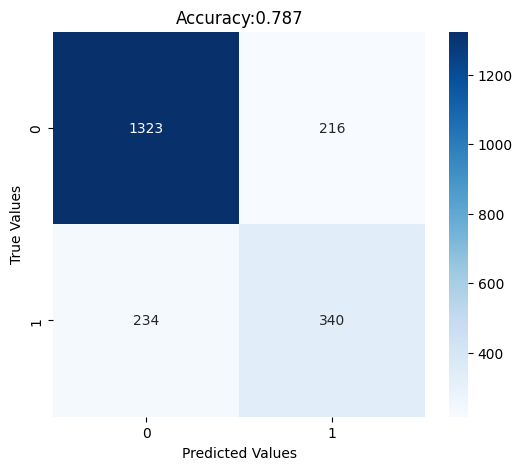

In [288]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

Although Random Forest model has the highest accuracy score on the training set compared to all the algorithms tested, its performance on the test set is lower, with a significant gap between the two. It also struggles to predict class 1 (churn) effectively.

In [ ]:
# Evaluate AdaBoost model 
best_ada = grid_search_ada.best_estimator_

y_pred = best_ada.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.751538097491718 0.7748153128983253 0.7224400899406809 0.6435845213849287


In [290]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1539
           1       0.53      0.83      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.75      0.76      2113



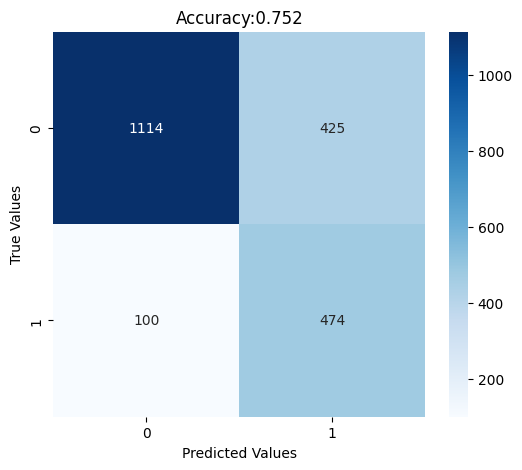

In [291]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

AdaBoost model has an accuracy score on the training set that is close to the accuracy on the test set (helping avoid overfitting), and its recall for class 1 (churn) is the highest among all the algorithms. Since the goal of the problem is to identify churned customers, the model that can correctly predict the most churned customers should be selected. Therefore, **AdaBoost model** is the best choice.

In [ ]:
# Evaluate SVC model 
best_svc = model_grid_svc.best_estimator_

y_pred = best_svc.predict(X_test)

score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7089446284902982 0.6685622140264844 0.6497979964629261 0.5199063231850117


In [293]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1539
           1       0.47      0.58      0.52       574

    accuracy                           0.71      2113
   macro avg       0.65      0.67      0.66      2113
weighted avg       0.73      0.71      0.72      2113



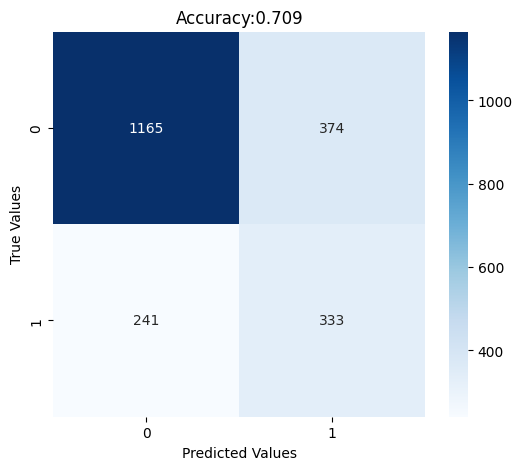

In [294]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

Although SVC model has a high accuracy score on the training set, its performance on the test set is lower, with a significant gap between the two. It also struggles to predict class 1 (churn) effectively.

## Identify the 10 most important features and apply them to the chosen algorithm

In [ ]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [ ]:
# The 10 features most strongly correlated with the Churn variable.
selected_features_idx = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features_idx]
selected_feature_names

Index(['SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity',
       'TechSupport', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')

In [ ]:
model_ada=AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.0, n_estimators=100)
model_ada.fit(X_train_selected, y_train)

y_pred = model_ada.predict(X_test_selected)

score_train=model_ada.score(X_train_selected, y_train)
score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score_train, score, recall, precision, f1)

0.7731774415405778 0.7468054898248935 0.7721126438499138 0.719521160305455 0.6397306397306397


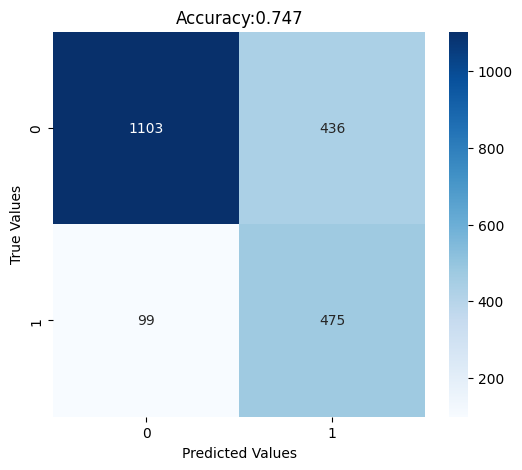

In [69]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{score:.3f}')
plt.show()

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.80      1539
           1       0.52      0.83      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.75      0.76      2113



After selecting the 10 most correlated features, the model shows a slight improvement. However, additional churn customer data is needed for better prediction performance.